## Imports:

In [ ]:
# General
import os  
import sys
import time
import warnings
import multiprocessing
from time import time
from random import randrange
import math
import heapq # for retrieval topK
import multiprocessing
import pickle

# Data Science
import numpy  as np
import scipy  as sp
import pandas as pd

# Visual
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# Notebook
from IPython.display import display, HTML

# Deep
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Dense,Lambda,Activation
from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adamax
from tensorflow.keras.models import Sequential,Model,load_model,save_model
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Embedding,Input,Dense,Reshape,Flatten,Dropout,Multiply,Concatenate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### CONSTANTS:

In [ ]:
#  From Asi's notebook used also in HW3

K = 5 # used to evaluate the model. Top K recommendations are used.
num_factors = 8 # size of embedding size. Can be split to 4 different params potentially.
num_negatives = 4 # how many negative samples per positive sample?
learning_rate = 0.001
batch_size = 256
verbose = 1
epochs = 10

#### Preprocessing:

In [ ]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']

# Read the training file
train = pd.read_csv('./drive/My Drive/RecSys/neural_collaborative_filtering/Data/ml-1m.train.rating', sep='\t', names=column_names)

# Read the test file
test_rating = pd.read_csv('./drive/My Drive/RecSys/neural_collaborative_filtering/Data/ml-1m.test.rating', sep='\t', names=column_names)


negative_ids = ['(user_id, item_id)']

for i in range(1,100):
    negative_ids.append(f'id-{i}')

test_negative = pd.read_csv('./drive/My Drive/RecSys/neural_collaborative_filtering/Data/ml-1m.test.negative', sep='\t', names=negative_ids)

In [ ]:
train.head()

,user_id,item_id,rating,timestamp
0,0,32,4,978824330
1,0,34,4,978824330
2,0,4,5,978824291
3,0,35,4,978824291
4,0,30,4,978824291


In [ ]:
def get_train_instances(train, num_negatives):
    user_input, item_input, labels = [0]*((num_negatives + 1)*len(train)),[0]*((num_negatives + 1)*len(train)),[1]
    ratings_random = [0]*((num_negatives + 1)*len(train)) # for section E
    num_users = train.shape[0]
    all_items = train.item_id.unique().argsort()

    negatives = [0]*num_negatives
    labels.extend(negatives)
    total_labels = labels*len(train)
#     list(map(lambda x: total_labels.extend(labels), range(len(train))))
#     return
    percent_1 = int(len(train)/100)
    
    items_the_user_didnt_rank = None
    prev_user = -1
    chosen_item_per_user = []

    for idx_i in range(len(train)):
        curr_index = idx_i * (num_negatives + 1)

        # if idx_i != 0 and idx_i % percent_1 == 0:
        #     print(f'{int(idx_i/percent_1)}%')
        
        u = train.iloc[idx_i].user_id
        i = train.iloc[idx_i].item_id

        user_input[curr_index:curr_index + (num_negatives + 1)] = [u]*(num_negatives + 1)
        item_input[curr_index] = i

        ### for section E - start
        r = train.iloc[idx_i].rating # get rating of user to movie

        ratings_random[curr_index] = r

        for i in range(1, num_negatives+1):
          # When no rating available, random rating 
          ratings_random[curr_index+i] = randrange(1,5)
        ### for section E - end

        if u != prev_user:
            items = train[train['user_id'] == u].item_id.to_numpy().argsort()
            items_the_user_didnt_rank = all_items[~np.in1d(all_items,items)]
            prev_user = u
#             chosen_item_per_user = []

#         items_the_user_didnt_rank = items_the_user_didnt_rank[~np.in1d(items_the_user_didnt_rank,chosen_item_per_user)]
        sample_items = items_the_user_didnt_rank[np.random.choice(len(items_the_user_didnt_rank), size=num_negatives, replace=False)]
        item_input[curr_index+1:curr_index + (num_negatives + 1)] = sample_items
#         chosen_item_per_user.extend(sample_items)
    
    print('DONE')

    return user_input, item_input, total_labels, ratings_random

In [ ]:
# This takes a couple of minutes...
training_data = get_train_instances(train, num_negatives)

DONE


In [ ]:
user_input, item_input, labels, ratings_random = training_data

In [ ]:
num_users = len(set(user_input))
num_items = len(set(item_input))

print(num_users)
print(num_items)

6040
3706


***
## Question 1: Matrix Factorization with custom loss

A) Answer:

Given
$$
L=-\frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j}\left(y_{i, j} \log \left(\sigma\left(\mu+p_{i}+o_{j}+\boldsymbol{u}_{i}^{T} v_{j}\right)\right)+\left(1-y_{i, j}\right) \log \left(1-\sigma\left(\mu+p_{i}+o_{j}+\boldsymbol{u}_{i}^{T} v_{j}\right)\right)\right)
$$

Note that:
$$
\log (\sigma (z)) \\
= \log (\frac{1}{1+e^{-z}}) \\
= \log(1) - \log(1+e^{-z}) \\
= -\log(1+e^{-z})
$$
* (Here, we used the fact that $\log(\frac{x}{y}) = \log(x) - \log(y)$)

Similarly:
$$
\log (1 - \sigma (z)) \\
= \log (1 - \frac{1}{1+e^{-z}}) \\
= \log (\frac{1+e^{-z} - 1}{1+e^{-z}}) \\
= \log (\frac{e^{-z}}{1+e^{-z}}) \\
= \log(e^{-z}) - \log(1+e^{-z}) \\
= -z - \log(1+e^{-z}) \\
= -\big( z + \log(1+e^{-z}) \big)
$$


**Denote** $\boldsymbol{z = \mu+p_{i}+o_{j}+{u}_{i}^{T} v_{j}}$ <br>
Now, using $z$ and plugging in the two simplified expressions from above, we obtain:
$$
L=-\frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j}\left(y_{i, j} \log \left(\sigma\left(z\right)\right)+\left(1-y_{i, j}\right) \log \left(1-\sigma\left(z\right)\right)\right) \\
=-\frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j}\left(-1 \cdot y_{i, j} \log(1+e^{-z}) +\left(1-y_{i, j}\right) 
\left( -(z + \log(1+e^{-z}))\right)\right) \\
=-\frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j}\left(-1 \cdot y_{i, j} \log(1+e^{-z}) - \left(1-y_{i, j}\right)(z + \log(1+e^{-z})) \right) \\
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j}\left(y_{i, j} \log(1+e^{-z}) + \left(1-y_{i, j}\right)(z + \log(1+e^{-z})) \right) \\
$$

After opening up the multiplications, we end up with:
$$
L= \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j}\left( z - y_{i, j} z + \log(1+e^{-z}) \right)
$$


- Reference: https://math.stackexchange.com/questions/477207/derivative-of-cost-function-for-logistic-regression

All we need now is to compute the partial derivatives of $L$ w.r.t the user and item latent vector weights ($u_i,  v_j$), the global bias ($\mu$), user bias ($p_i$) and item bias ($o_j$) variables for user i and item j.<br>
The update rules are:
$$
u = u - \frac{\partial L}{\partial u} \\
v = v - \frac{\partial L}{\partial v} \\
\mu = \mu - \frac{\partial L}{\partial \mu} \\
p = p - \frac{\partial L}{\partial p} \\
o = o - \frac{\partial L}{\partial o}
$$

Using the "Chain Rule" - we solve each derivative separately and then plug back in:


- **user latent vector weights ($u_i$):**
$$
\frac{\partial [\alpha_{j} z]}{\partial u_i}
= \frac{\partial [\alpha_{j} (\mu+p_{i}+o_{j}+{u}_{i}^{T} v_{j})]}{\partial u_i} 
= \alpha_{j} v_{j}
$$

$$
\frac{\partial [-\alpha_{j}  y_{i, j} z]}{\partial u_i}
= \frac{\partial [- \alpha_{j} y_{i, j}(\mu+p_{i}+o_{j}+{u}_{i}^{T} v_{j})]} {\partial u_i} 
= -\alpha_{j} y_{i, j} v_{j}
$$


$$
\frac{\partial [\alpha_{j}  \log(1+e^{-z})]}{\partial u_i}
= \frac{\alpha_j e^{-z} \frac{\partial z}{\partial u_i}} {1 + e^{-z}}
= - \frac{\alpha_{j} e^{-z} v_{j}}{1 + e^{-z}}
$$

* (Last transition, log derivative, follows from [here](https://www.symbolab.com/solver/step-by-step/%5Cleft(log_%7Be%7D%5Cleft(1%2Be%5E%7B-2x%7D%5Cright)%5Cright)%5E%7B'%7D))

Hence,
$$
\frac{\partial L}{\partial u_i}
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \big( \alpha_{j} v_{j} - \alpha_{j} y_{i, j} v_{j} - \frac{\alpha_{j} e^{-z} v_{j}}{1 + e^{-z}} \big) 
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j} v_{j} \big( 1 - y_{i, j} - \frac{e^{-z}}{1 + e^{-z}} \big) 
$$


- **item latent vector weights ($v_j$)** is very similar, since both terms are multiplied with each other:
$$
\frac{\partial L}{\partial v_j}
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \big( \alpha_{j} {u}_{i}^{T} - \alpha_{j} y_{i, j} {u}_{i}^{T} - \frac{\alpha_{j} e^{-z} {u}_{i}^{T}}{1 + e^{-z}} \big) 
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j} {u}_{i}^{T} \big( 1 - y_{i, j} - \frac{e^{-z}}{1 + e^{-z}} \big) 
$$


- **the global bias, $\mu$:**
$$
\frac{\partial [\alpha_{j} z]}{\partial \mu}
= \frac{\partial [\alpha_{j} (\mu+p_{i}+o_{j}+{u}_{i}^{T} v_{j})]}{\partial \mu} 
= \alpha_{j}
$$

$$
\frac{\partial [-\alpha_{j}  y_{i, j} z]}{\partial \mu}
= \frac{\partial [- \alpha_{j} y_{i, j}(\mu+p_{i}+o_{j}+{u}_{i}^{T} v_{j})]} {\partial \mu} 
= -\alpha_{j} y_{i, j}
$$

$$
\frac{\partial [\alpha_{j}  \log(1+e^{-z})]}{\partial \mu}
= \frac{\partial [\alpha_{j} \log(1 + e^{\mu+p_{i}+o_{j}+{u}_{i}^{T} v_{j}})]} {\partial \mu} 
= \frac{\alpha_j e^{-z} \frac{\partial z}{\partial u_i}} {1 + e^{-z}}
= - \frac{\alpha_{j} e^{-z}}{1 + e^{-z}}
$$

Hence,
$$
\frac{\partial L}{\partial \mu}
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \big( \alpha_{j} - \alpha_{j} y_{i, j} - \frac{\alpha_{j} e^{-z}}{1 + e^{-z}} \big) 
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j} \big( 1 - y_{i, j} - \frac{e^{-z}}{1 + e^{-z}} \big) 
$$


- **user bias $p_i$** follows the same calculation as $\mu$ since it's added as a standalone addition:
$$
\frac{\partial L}{\partial p_i}
= \frac{\partial L}{\partial \mu}
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j} \big( 1 - y_{i, j} - \frac{e^{-z}}{1 + e^{-z}} \big) 
$$


- **item bias $o_j$** follows the same calculation as $\mu$ since it's added as a standalone addition:
$$
\frac{\partial L}{\partial o_j}
= \frac{\partial L}{\partial \mu}
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j} \big( 1 - y_{i, j} - \frac{e^{-z}}{1 + e^{-z}} \big) 
$$

***
B) Answer:

Given the prices of the different items from the catalog, we can set the weights for each training instance based on the **item price divided by the maximal price** we have.
Meaning, we're giving each weight its relative "significance".

This is very intuitive and straightforward - The more expensive an item is, the larger weight it's given, where weights' values range from 0 to 1.

***
## Question 2: Neural Collaborative Filtering

##### A)

In [ ]:
item_price = pd.read_csv('./drive/My Drive/RecSys/item_price.csv')
item_price.set_index('item')

,price
item,
0,4
1,1
2,1
3,2
4,2
...,...
3701,25
3702,4
3703,1


In [ ]:
qprices = item_price['price']

([<matplotlib.axis.XTick at 0x7ff90afea400>,
 <a list of 5 Text major ticklabel objects>)

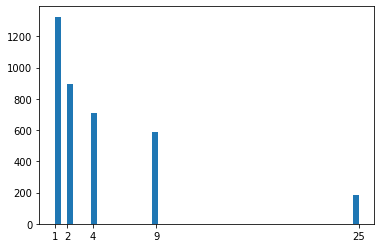

In [ ]:
plt.hist(item_price.price, align='mid', bins=50)
plt.xticks(item_price.price.unique())

In [ ]:
item_price.groupby('price')['item'].nunique()

price
1     1326
2      896
4      709
9      589
25     186
Name: item, dtype: int64

In [ ]:
item_price.describe()

,item,price
count,3706.000000,3706.000000
mean,1852.500000,4.291689
std,1069.974377,5.496992
min,0.000000,1.000000
25%,926.250000,1.000000
50%,1852.500000,2.000000
75%,2778.750000,4.000000
max,3705.000000,25.000000


There are 3706 items with prices distributed from [1, 2, 4, 9, 25].<br>
From the histogram and the data we see that most of the items are priced 2 and lower - ((1: 1326), (2: 896), (4: 709), (9: 589), (25: 186))<br>
It doesn't look like we can deduce a behaviour of a specific distribution (like normal/uniform etc.), especially since we don't have enough data other than ID numbers and prices...<br>

***
##### B)

In [ ]:
def get_revenue_k(rank_list, gt_item):
    for item in rank_list:
        if item == gt_item:
            return list(item_price[item_price.item == item].price)[0]
    return 0

***
##### C)

We can incorporate the ranking together with the item price:<br>
The custom metric is a simple multiplication of Revenue@K from section B above with the NDCG metric we used in the previous assignment and also here during the evaluation in section E.<br>
This is suitable because the higher the hit rank, the larger the NDCG value.<br>
Therefore, the result will also be larger after the multiplication (becasue all prices are larger from/equal to 1).<br>
This should work also with MRR for the same reasons.

In [ ]:
def get_custom_metric(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return (list(item_price[item_price.item == item].price)[0]) * (math.log(2) / math.log(i+2))
    return 0

***
##### D)

In [ ]:
def get_GMF_model(num_users, num_items, latent_dim, regs=None, activation='sigmoid'):
    '''Generalized Matrix Factorization'''

    if not regs:
        regs = [[0,0]]
    
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding',
                                   embeddings_regularizer = l2(regs[0][0]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) #init = init_normal,
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding',
                                   embeddings_regularizer = l2(regs[0][1]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01))  #init = init_normal, 
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    
    # Element-wise product of user and item embeddings 
    predict_vector = Multiply()([user_latent, item_latent]) #merge([user_latent, item_latent], mode = 'mul')
    
    # Final prediction layer
    prediction = Dense(1, activation=activation, kernel_initializer='lecun_uniform', name = 'prediction')(predict_vector)
    model = Model(inputs=[user_input, item_input], outputs=prediction)
    
    return model


def build_model():
    gmf_model = get_GMF_model(num_users, num_items, num_factors, regs = [[0,0]])
    gmf_model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy')
    return gmf_model

**Since our loss function here is a Weighted Binary Cross Entropy, I passed the normal loss='binary_crossentropy' above in the "compile" function and incorporated the movie price vector to the loss function as part of the training in the model.fit as an extra attribute called "sample_weight".**

***
##### E) 
Compare the results of the original model and the one with the customized loss across the four metrics: MRR@5, NDCG@5, Revenue@5, your custom metric

In [ ]:
def evaluate_model(model, test_ratings, test_negatives, K):
    """
    Evaluate the performance (MRR, NDCG, REV@K, my_custom_metric) of top-K recommendation
    Return: score of each test rating.
    """
    mrrs, ndcgs, revenue_K, my_custom_metric = zip(*[eval_one_rating(model, test_ratings, test_negatives, idx, K) for idx in range(len(test_ratings))])
    return np.array(mrrs).mean(), np.array(ndcgs).mean(), np.array(revenue_K).mean(), np.array(my_custom_metric).mean()


def eval_one_rating(model, test_ratings, test_negatives, idx, K):
    u = test_ratings.iloc[idx].user_id
    gtItem = test_ratings.iloc[idx].item_id
    items = test_negatives[test_negatives['(user_id, item_id)'] == f'({u},{gtItem})'].to_numpy()[0]
    items = items[1:len(items)].astype('int32')
    items = np.append(items, gtItem)
    users = np.full(len(items), u, dtype = 'int32')
    # Get prediction scores
    map_item_score = {}

    predictions = model.predict([users, np.array(items)], 
                                 batch_size=100, verbose=0)
    
    for i in range(len(items)):
        item = items[i]
        map_item_score[item] = predictions[i]
    
    items = items[:len(items)-1]
    
    # Evaluate top rank list
    ranklist = heapq.nlargest(K, map_item_score, key=map_item_score.get)
    mrr = getMRR(ranklist, gtItem)
    ndcg = getNDCG(ranklist, gtItem)
    rev_K = get_revenue_k(ranklist, gtItem)
    my_custom_metric = get_custom_metric(ranklist, gtItem)

    return mrr, ndcg, rev_K, my_custom_metric


def getMRR(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return 1/(i+1)
    return 0


def getNDCG(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return math.log(2) / math.log(i+2)
    return 0

In [ ]:
def initPerformance(name, model):
    t1 = time()
    mrr, ndcg, rev_K, my_custom_metric = evaluate_model(model, test_rating, test_negative, K)
    return mrr, ndcg, rev_K, my_custom_metric

In [ ]:
item_input_np = np.array(item_input)
prices_np = qprices.to_numpy()
prices_np = qprices[item_input_np]

In [ ]:
gmf_model = build_model()
mrr_GMF, ndcg_GMF, revenue_K_GMF, custom_metric_GMF = initPerformance('GMF', gmf_model)

In [ ]:
test_rating

,user_id,item_id,rating,timestamp
0,0,25,5,978824351
1,1,133,3,978300174
2,2,207,4,978298504
3,3,208,4,978294282
4,4,222,2,978246585
...,...,...,...,...
6035,6035,1048,1,956755196
6036,6036,294,4,956801840
6037,6037,1528,5,956717204
6038,6038,1449,5,956758029


In [ ]:
# Train model
def train_eval_model(sample_weight=None):
    model_name, model, mrr, ndcg, revenue_K, custom_metric = 'GMF', gmf_model, mrr_GMF, ndcg_GMF, revenue_K_GMF, custom_metric_GMF

    user_input_np = np.array(user_input)
    item_input_np = np.array(item_input)
    labels_np = np.array(labels)

    best_mrr, best_ndcg, revenue_K, custom_metric, best_iter = mrr, ndcg, revenue_K, custom_metric, -1
    print(f"Running on Model: {model_name}, using K: {K}")

    epoch_result = []
    for epoch in range(epochs):
        # Generate training instances
        # Training
        print("Training")
        hist = model.fit([user_input_np, item_input_np], #input
                        labels_np, # labels
                        sample_weight=sample_weight, # THIS IS WHAT I REFERRED TO IN SECTION D
                        batch_size=batch_size, epochs=1, verbose=0, shuffle=True)
        print("Finished training")            

        # Evaluation
        print("Evaluating")      
        if epoch % verbose == 0:    
            mrr, ndcg, revenue_K, custom_metric = evaluate_model(model, test_rating, test_negative, K)
            loss = hist.history['loss'][0]  
            print(f'Iteration {epoch} [k: {K}, Rev@K = {revenue_K:.4f}, custom_metric = {custom_metric:.4f}, MRR = {mrr:.4f}, NDCG = {ndcg:.4f}, loss = {loss:.4f}')

            if mrr > best_mrr:
                best_mrr, best_ndcg, best_revenue_K, best_custom_metric, best_iter = mrr, ndcg, revenue_K, custom_metric, epoch
        epoch_result.append((epoch, mrr, ndcg, revenue_K, custom_metric, loss))
        print(f"---------End Epoch: {epoch}---------")

    print(f'End. Best Iteration = {best_iter}: Rev@K = {best_revenue_K:.4f}, custom_metric = {best_custom_metric:.4f}, MRR = {best_mrr:.4f}, NDCG = {best_ndcg:.4f}')
    return epoch_result

**This is the original model (as shown in HW3) - no weights (prices) are included, a simple Binary Cross Entropy loss function:**

In [ ]:
epoch_result_gmf_1 = train_eval_model()

with open('./drive/My Drive/RecSys/epoch_result_gmf_1.pkl', 'wb') as f:
  pickle.dump(epoch_result_gmf_1, f)

Running on Model: GMF, using K: 5
Training
Finished training
Evaluating
Iteration 0 [k: 5, Rev@K = 1.1808, custom_metric = 0.6917, MRR = 0.1225, NDCG = 0.1543, loss = 0.3510
---------End Epoch: 0---------
Training
Finished training
Evaluating
Iteration 1 [k: 5, Rev@K = 1.4348, custom_metric = 0.8345, MRR = 0.1410, NDCG = 0.1800, loss = 0.3149
---------End Epoch: 1---------
Training
Finished training
Evaluating
Iteration 2 [k: 5, Rev@K = 1.5230, custom_metric = 0.9039, MRR = 0.1493, NDCG = 0.1901, loss = 0.2959
---------End Epoch: 2---------
Training
Finished training
Evaluating
Iteration 3 [k: 5, Rev@K = 1.6406, custom_metric = 0.9654, MRR = 0.1599, NDCG = 0.2040, loss = 0.2836
---------End Epoch: 3---------
Training
Finished training
Evaluating
Iteration 4 [k: 5, Rev@K = 1.6609, custom_metric = 0.9668, MRR = 0.1649, NDCG = 0.2102, loss = 0.2776
---------End Epoch: 4---------
Training
Finished training
Evaluating
Iteration 5 [k: 5, Rev@K = 1.7209, custom_metric = 1.0012, MRR = 0.1669, 

In [ ]:
# print results
file_1 = open('./drive/My Drive/RecSys/epoch_result_gmf_1.pkl', 'rb')
results_1 = pickle.load(file_1)
for item in results_1:
    print(item)

(0, 0.12253035320088301, 0.15427461920680063, 1.180794701986755, 0.6917461816641723, 0.3509752154350281)
(1, 0.14104580573951433, 0.18003397062043427, 1.4347682119205298, 0.8344554873679654, 0.3149268627166748)
(2, 0.14926324503311258, 0.19014109033119964, 1.5230132450331126, 0.903851749563237, 0.29589301347732544)
(3, 0.1598647902869757, 0.2040466435932046, 1.6405629139072848, 0.9654275879659132, 0.2836102545261383)
(4, 0.16491721854304636, 0.2102017333175476, 1.6609271523178808, 0.9668400052478318, 0.27755141258239746)
(5, 0.16687913907284768, 0.21393741071596292, 1.7208609271523179, 1.001206502207919, 0.2741599380970001)
(6, 0.16968267108167773, 0.21625882105785907, 1.721523178807947, 1.0096199358707751, 0.2719229459762573)
(7, 0.1702621412803532, 0.21721098046157425, 1.719701986754967, 1.0030482701899075, 0.2703869640827179)
(8, 0.1709933774834437, 0.21848699722334922, 1.7153973509933775, 1.003683196572968, 0.269275963306427)
(9, 0.17342439293598233, 0.22158353188568408, 1.76771523

**This is the model with the customized loss - weights (prices) are included, a Weighted Binary Cross Entropy loss function:**

In [ ]:
# prices_np is simply a vector of the prices of each items
epoch_result_gmf_2 = train_eval_model(sample_weight=prices_np)

with open('./drive/My Drive/RecSys/epoch_result_gmf_2.pkl', 'wb') as f:
  pickle.dump(epoch_result_gmf_2, f)

Running on Model: GMF, using K: 5
Training
Finished training
Evaluating
Iteration 0 [k: 5, Rev@K = 1.7209, custom_metric = 1.0087, MRR = 0.1710, NDCG = 0.2180, loss = 1.1777
---------End Epoch: 0---------
Training
Finished training
Evaluating
Iteration 1 [k: 5, Rev@K = 1.7634, custom_metric = 1.0343, MRR = 0.1738, NDCG = 0.2220, loss = 1.1675
---------End Epoch: 1---------
Training
Finished training
Evaluating
Iteration 2 [k: 5, Rev@K = 1.8063, custom_metric = 1.0597, MRR = 0.1731, NDCG = 0.2215, loss = 1.1630
---------End Epoch: 2---------
Training
Finished training
Evaluating
Iteration 3 [k: 5, Rev@K = 1.7553, custom_metric = 1.0351, MRR = 0.1738, NDCG = 0.2214, loss = 1.1598
---------End Epoch: 3---------
Training
Finished training
Evaluating
Iteration 4 [k: 5, Rev@K = 1.7382, custom_metric = 1.0326, MRR = 0.1723, NDCG = 0.2201, loss = 1.1574
---------End Epoch: 4---------
Training
Finished training
Evaluating
Iteration 5 [k: 5, Rev@K = 1.7083, custom_metric = 1.0119, MRR = 0.1705, 

In [ ]:
# print results
file_2 = open('./drive/My Drive/RecSys/epoch_result_gmf_2.pkl', 'rb')
results_2 = pickle.load(file_2)
for item in results_2:
    print(item)

(0, 0.17102373068432672, 0.21798879226103482, 1.7208609271523179, 1.0086794341885048, 1.1776763200759888)
(1, 0.1737555187637969, 0.22203696038175985, 1.76341059602649, 1.0343421930196626, 1.1674628257751465)
(2, 0.17308774834437088, 0.22147752090963846, 1.8062913907284768, 1.0597007857354923, 1.163025140762329)
(3, 0.1738051876379691, 0.22142064768852562, 1.755298013245033, 1.0350746529788506, 1.159832239151001)
(4, 0.1722682119205298, 0.220096443516555, 1.7382450331125827, 1.0325939981123322, 1.1574254035949707)
(5, 0.1704635761589404, 0.2177547712229446, 1.7082781456953642, 1.0118746859243124, 1.1552218198776245)
(6, 0.1707864238410596, 0.2183640108378393, 1.7667218543046357, 1.049967099009223, 1.1536403894424438)
(7, 0.1728283664459161, 0.2212635961653858, 1.7456953642384105, 1.030852081083722, 1.1521415710449219)
(8, 0.17411699779249445, 0.22204078405221636, 1.7587748344370862, 1.0458438963828323, 1.1508269309997559)
(9, 0.17216059602649006, 0.22036215798065636, 1.7541390728476822

<br>
- Compare between different heuristics of item price to weights mapping. 

Choose a random rating for negative items

In [ ]:
# ratings_random is simply a vector of ratings and random rating when no rating existing (values 1-5 inclusive === 1-6 exclusive)
prices_np_random = prices_np.to_numpy()*np.array(ratings_random)

# prices_np_random is a vector of the item price, multiplied by a (random) rating (values 1-5) for that item (movie)
epoch_result_gmf_3 = train_eval_model(sample_weight=prices_np_random)

with open('./drive/My Drive/RecSys/epoch_result_gmf_3.pkl', 'wb') as f:
  pickle.dump(epoch_result_gmf_3, f)

Running on Model: GMF, using K: 5
Training
Finished training
Evaluating
Iteration 0 [k: 5, Rev@K = 1.7422, custom_metric = 1.0434, MRR = 0.1709, NDCG = 0.2176, loss = 3.3381
---------End Epoch: 0---------
Training
Finished training
Evaluating
Iteration 1 [k: 5, Rev@K = 1.7036, custom_metric = 1.0055, MRR = 0.1696, NDCG = 0.2170, loss = 3.3203
---------End Epoch: 1---------
Training
Finished training
Evaluating
Iteration 2 [k: 5, Rev@K = 1.7272, custom_metric = 1.0230, MRR = 0.1715, NDCG = 0.2190, loss = 3.3140
---------End Epoch: 2---------
Training
Finished training
Evaluating
Iteration 3 [k: 5, Rev@K = 1.7066, custom_metric = 1.0138, MRR = 0.1708, NDCG = 0.2176, loss = 3.3092
---------End Epoch: 3---------
Training
Finished training
Evaluating
Iteration 4 [k: 5, Rev@K = 1.7358, custom_metric = 1.0294, MRR = 0.1709, NDCG = 0.2190, loss = 3.3062
---------End Epoch: 4---------
Training
Finished training
Evaluating
Iteration 5 [k: 5, Rev@K = 1.7368, custom_metric = 1.0390, MRR = 0.1721, 

In [ ]:
# print results
file_3 = open('./drive/My Drive/RecSys/epoch_result_gmf_3.pkl', 'rb')
results_3 = pickle.load(file_3)
for item in results_3:
    print(item)

(0, 0.17086092715231788, 0.21757426527710638, 1.7422185430463577, 1.0434132885806715, 3.338054656982422)
(1, 0.16960264900662253, 0.21701757499326474, 1.7036423841059603, 1.0054610675809614, 3.320298910140991)
(2, 0.1714900662251656, 0.21901202594291316, 1.7271523178807946, 1.0229587047077047, 3.3139777183532715)
(3, 0.17083333333333336, 0.21761169784685647, 1.7066225165562914, 1.0137979760800577, 3.309157133102417)
(4, 0.1709188741721854, 0.21902785250263093, 1.7357615894039735, 1.0294246253085255, 3.3061790466308594)
(5, 0.1721412803532009, 0.21950948827758263, 1.7367549668874172, 1.039049056960776, 3.30281925201416)
(6, 0.17052980132450332, 0.21764350131948462, 1.7364238410596027, 1.0371700800786712, 3.300384044647217)
(7, 0.17278973509933773, 0.22043823939890597, 1.7334437086092715, 1.0384372748887496, 3.2981529235839844)
(8, 0.17113962472406183, 0.21854686329045023, 1.7326158940397351, 1.0344745609376584, 3.296098232269287)
(9, 0.17232064017660043, 0.22037553740202157, 1.759437086

<br>
- Present the comparison results, discuss the results and the trade-offs and optimize

**See the results after each run of "train_eval_model" above (3 times)**<br>

We also plot the results below and then we discuss the results.

<br>
- Verify and present that the learning is ‘healthy’ (no overfitting, no under-fitting and that the results make sense)

Each row in the pickle results files is of the format:<br>
EPOCH_NUMBER, MRR_VALUE, NDCG_VALUE, REV_K_VALUE, CUSTOM_METRIC_VALUE, LOSS_VALUE<br>

We read these files and plot them:

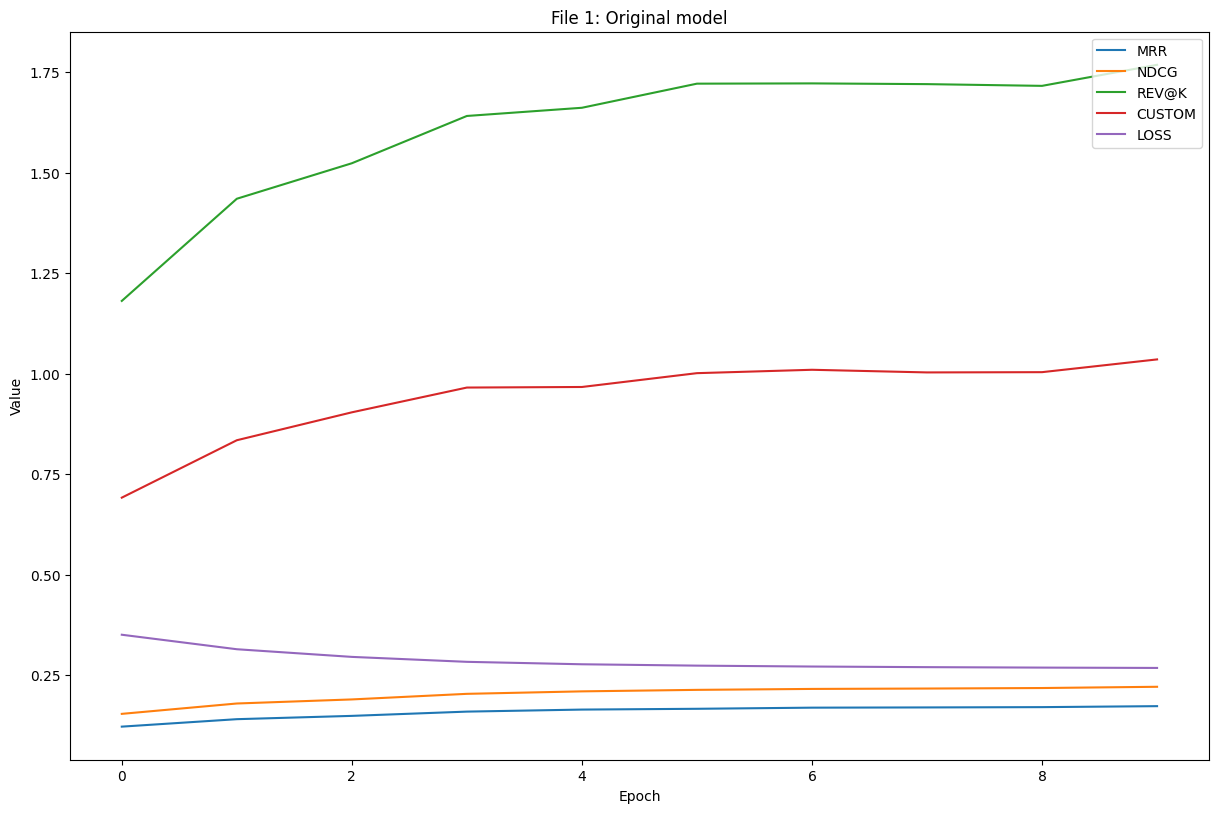

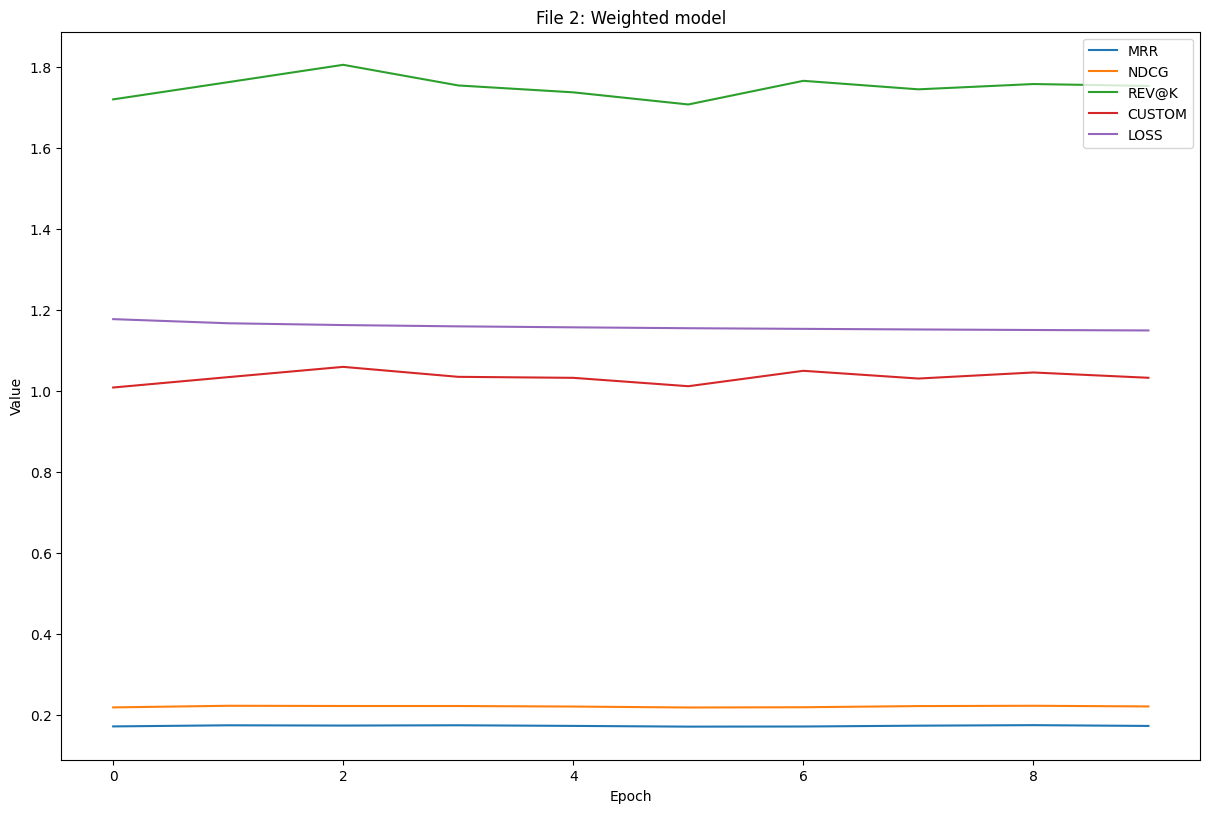

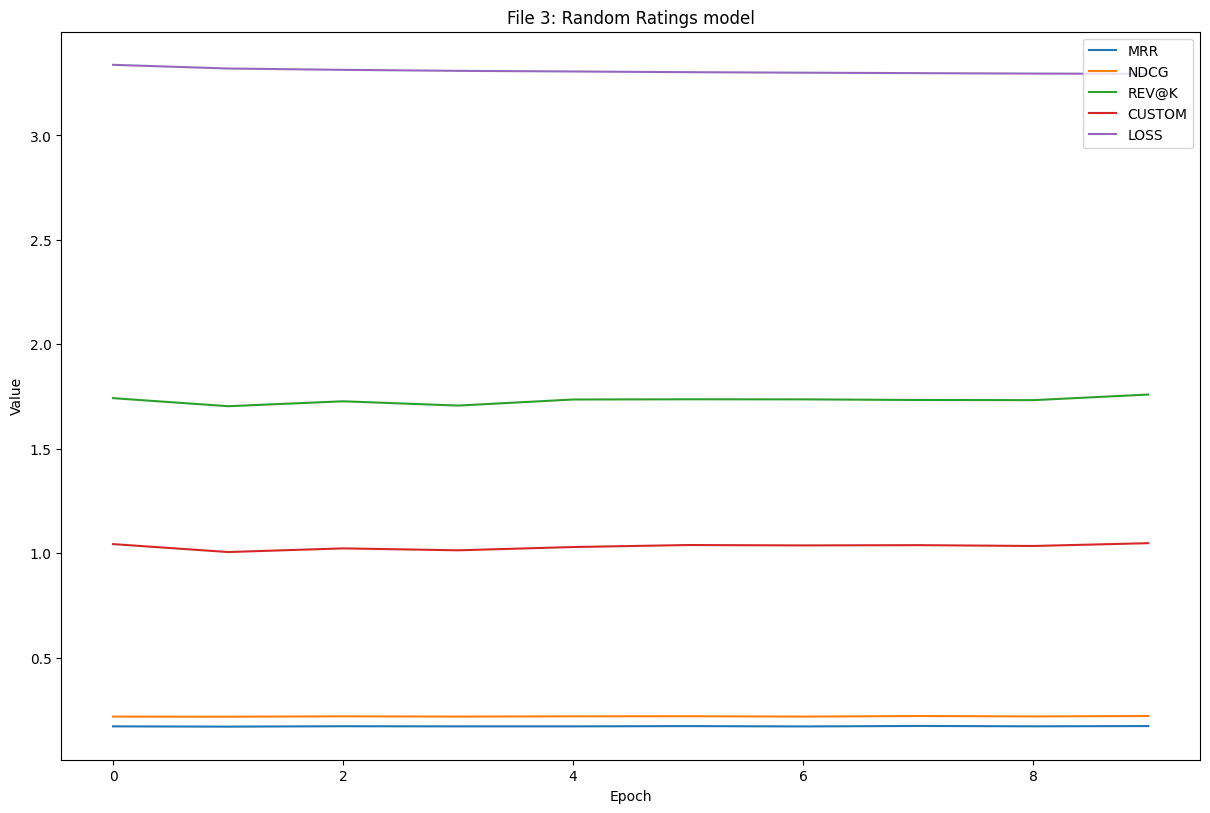

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

files = [('File 1: Original model', results_1), ('File 2: Weighted model', results_2), ('File 3: Random Ratings model', results_3)]
display_df_list = []

mrrs_all_algo = []
ndcg_all_algo = []
rev_k_all_algo = []
custom_metric_all_algo = []
loss_all_algo = []

for (name, data) in files:
    mrrs, ndcgs, rev_ks, custom_metrics, losses = [], [], [], [], []

    for line in data:
        mrrs.append(line[1])
        ndcgs.append(line[2])
        rev_ks.append(line[3])
        custom_metrics.append(line[4])
        losses.append(line[5])
        epochs = list(range(len(mrrs)))
        
        mrrs_all_algo.append((name, mrrs))
        ndcg_all_algo.append((name, ndcgs))
        rev_k_all_algo.append((name, rev_ks))
        custom_metric_all_algo.append((name, custom_metrics))
        loss_all_algo.append((name, losses))  
        
        display_df = pd.DataFrame(list(zip(mrrs, ndcgs, rev_ks, custom_metrics, losses, epochs)), 
               columns =['mrrs', 'ndcgs', 'rev_ks', 'custom_metrics', 'losss', 'epochs'])
        display_df_list.append((name,display_df))

    fig = plt.figure()
    fig.subplots_adjust(top=0.92, bottom=0.01, left=0.0010, right=0.95, hspace=0.5,
                        wspace=0.5)

    plt.plot(mrrs)
    plt.plot(ndcgs)
    plt.plot(rev_ks)
    plt.plot(custom_metrics)
    plt.plot(losses)
    plt.title(name)
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend(["MRR", "NDCG", "REV@K", "CUSTOM", "LOSS"], loc ="upper right")
    plt.show()

It seems like the MRR & NDCG values are not changing a lot for some reason...<br>
We expect Revenue@K & Custom to have higher values, because we also muliply two terms there.<br>
File 3 took much longer than the forst two - it probably has something to do with the ratings checks for each movie (and then provide a random rating for those missing).

***
## Question 3: Hybrid recommender systems
Cold start or users\items with a small number of interactions is a very common scenario in real world. In this question you will plan how you can leverage content based features to handle the cold start scenario.

A) Take a look at the original MovieLens 1M dataset. Which user and movie features could you use to enhance your recommender system and provide effective recommendations to users or items with a small number of ratings.

Looking at the 1M dataset, we see that:
- The user data has the format of **UserID::Gender::Age::Occupation::Zip-code**
- The movie data has the format of **MovieID::Title::Genres**

We can utilize all of these to improve recommendations to cold-start users/movies:

Intuitively and <u>generally speaking</u>, there are movies which are more for men and others which are more for women, so we can check the **user's gender** and recommend movies accordingly.<br>
It can help us recommend popular "women movies" to female-users with a small number of ratings, and similarly for male-users.

It can also work with the user's **age group**, such that young men are more likely to like "Fast & Furious" more than any other gender/age combination.

**Occupation** is also a good common denominator and can be realate to a similar taste among users - looking at an artist user with many rating, we can deduce his/hers taste to recommend movies for a new artist user.

**Zip-code** may be relevant to certain movies about a city/state.


Looking at movies, taking into account the **movies' genres**, it DOESN'T MATTER if some are unpopular or even COMPLETELY NEW - these features are what's really matter and if you liked/disliked a similar-genres movie, the systems predicts your rating for this one easily, although it has only a small number of ratings.

***

B) Describe a neural network based model to incorporate user or movie related features to the recommender system. Explain your suggestion.<br>
(There is no need to implement, provide pseudo code\visual)

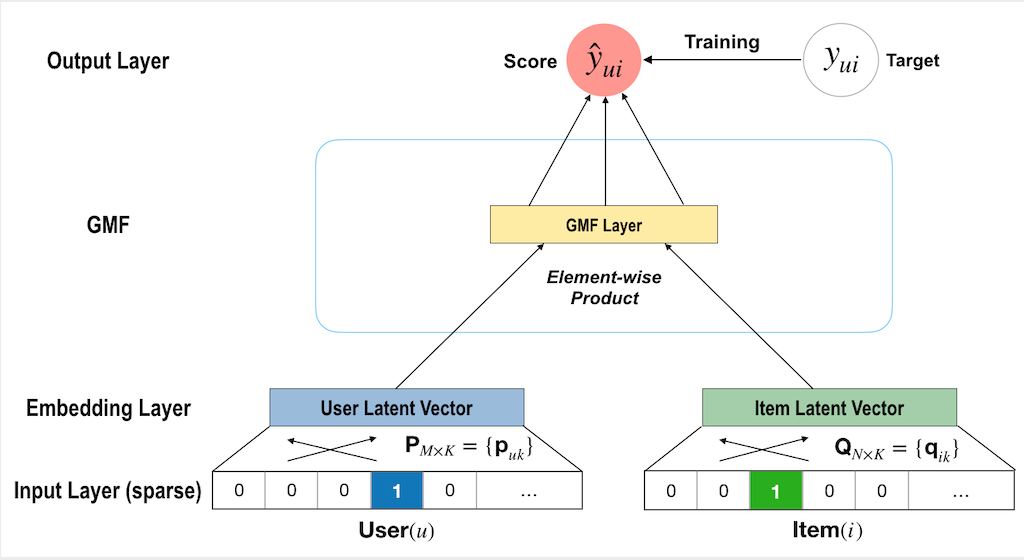

We can simply pass an embedding of the user gender or age, just like we passed the embedding of the user and item IDs in section D. 

In [ ]:
# Pseudo code
MF_Embedding_User_gender = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_gender_embedding', 
                              embeddings_regularizer = l2(regs[0][0]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) #init = init_normal,

# Similarly we construct embeddings for the other features.

***
C) How will you incorporate movie genres into the recommender system? How will you handle movies which belong to multiple genres? Explain the challenge and the proposed solution (there is no need to implement, provide pseudo-code).

Each user (and item) has a representation in the embedded plan.<br>
Here, the only difference with the other features is that it is not necessarily a 1-hot vector embeddding since a movie can be of a various of genres.<br>
The obtained movie-genre embedding (can be seen as the latent vector fora movie) is in the form of [1 0 0 1 1 0 0 1] such that each '1' indicates a different genre (drama, comedy, romance, etc.)